# Quantum Repeater Design

## Heralded Quantum Repeater

### Components

* QGen - perform entangled photons/qubits generation
* QSwap - performing quantum entanglement swapping
* Alice - represents sender
* Bob - represents destination/recipient
* QMem - stores qubits awaiting swapping protocol

In [114]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ, transpile, execute
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator, AerSimulator
from qiskit.circuit.library import RXGate
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel

In [115]:
def get_device_noise_model() -> (AerSimulator, NoiseModel):
    provider = IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')

    backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                       not b.configuration().simulator and b.status().operational==True))
    backend = AerSimulator.from_backend(backend)

    noise_model = NoiseModel.from_backend(backend)
    return backend, noise_model

In [116]:
backend, noise_model = get_device_noise_model()

ibmqfactory.load_account:WARNING:2022-10-14 16:13:52,294: Credentials are already in use. The existing account in the session will be replaced.
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (92038.51932346408 > 2 * 1552.3716846118762). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (92038.51932346408 > 2 * 1552.3716846118762). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/opt/conda/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxati

In [117]:
print("Backend:\n", backend)
print("\nNoise Model:\n", noise_model)

Backend:
 aer_simulator(ibmq_belem)

Noise Model:
 NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['sx', 'x', 'id', 'measure', 'cx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1

In [118]:
class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[0], a[1])
        qc.h(a[0])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[0], 0)
        qc.measure(a[1], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        # Apply the gates if the registers are in the state '1'
        if self.barrier: qc.barrier()
        qc.x(b).c_if(bsm_x, 1)
        qc.z(b).c_if(bsm_z, 1)

In [119]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)

In [120]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        # returns the circuit statevector
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    
    def qasm_sim(self, qc: QuantumCircuit) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        result = execute(qc, qasm_sim, shots=10240, noise_model=noise_model).result()
        return result.get_counts()
        # return qasm_sim.run(transpile(qc, qasm_sim), shots=10240).result().get_counts()

In [121]:
qgen_alice: QuantumRegister = QuantumRegister(2, "qgen_alice")
qgen_bob: QuantumRegister = QuantumRegister(2, "qgen_bob")

swap_channel: QuantumRegister = QuantumRegister(2, "swap_channel")

qmem: QuantumRegister = QuantumRegister(2, "qmem")

alice: QuantumRegister = QuantumRegister(1, "alice")
bob: QuantumRegister = QuantumRegister(1, "bob")

bsm_z: ClassicalRegister = ClassicalRegister(1, "bsm_zresult")
bsm_x: ClassicalRegister = ClassicalRegister(1, "bsm_xresult")

coz: ClassicalRegister = ClassicalRegister(1, "coz")
cox: ClassicalRegister = ClassicalRegister(1, "cox")

qc: QuantumCircuit = QuantumCircuit(qgen_alice, qgen_bob, qmem, alice, bob, swap_channel, bsm_z, bsm_x, coz, cox)

In [122]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qns: QuantumNativeSimulations = QuantumNativeSimulations()

In [123]:
qco.create_bell_pairs(qc, [qgen_alice, qgen_bob])

In [124]:
qc.barrier()
qc.swap(qgen_alice[0], qmem[0])
qc.swap(qgen_alice[1], alice)
qc.swap(qgen_bob[0], qmem[1])
qc.swap(qgen_bob[1], bob)

In [125]:
qc.barrier()
qc.swap(qmem[0], swap_channel[0])
qc.swap(qmem[1], swap_channel[1])

We can perform purification here first i.e. purification before the swapping protocol

In [126]:
qc.barrier()
qc.append(RXGate(np.pi/2), [alice])
qc.append(RXGate(-np.pi/2), [bob])
qc.append(RXGate(-np.pi/2), [swap_channel[0]])
qc.append(RXGate(np.pi/2), [swap_channel[1]])

qc.cx(alice, bob)
qc.cx(swap_channel[0], swap_channel[1])

In [127]:
qco.bell_state_operation(qc, swap_channel)

In [128]:
qco.bell_state_measurement(qc, swap_channel)

In [129]:
qco.pauli_correction_operation(qc, bob, bsm_z, bsm_x)

In [130]:
qc.barrier()
qc.cx(alice, bob)
qc.h(alice)

In [131]:
qc.barrier()
qc.measure(alice, coz)
qc.measure(bob, cox)

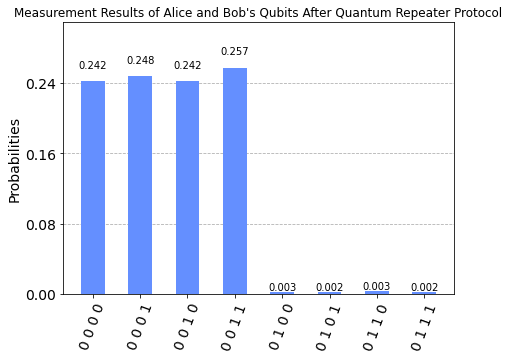

In [132]:
counts: Counts = qns.qasm_sim(qc)
plot_histogram(counts, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

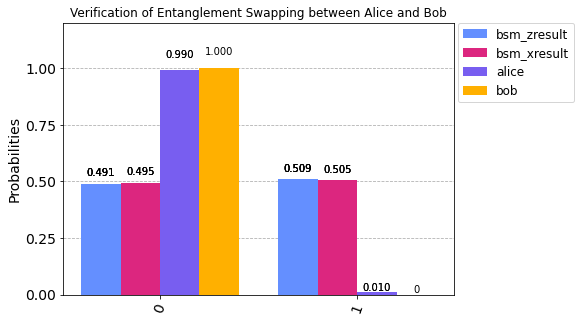

In [133]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(4)]
legend: list = ["bsm_zresult", "bsm_xresult", "alice", "bob"]
plot_histogram(qubit_counts, legend=legend, title="Verification of Entanglement Swapping between Alice and Bob")

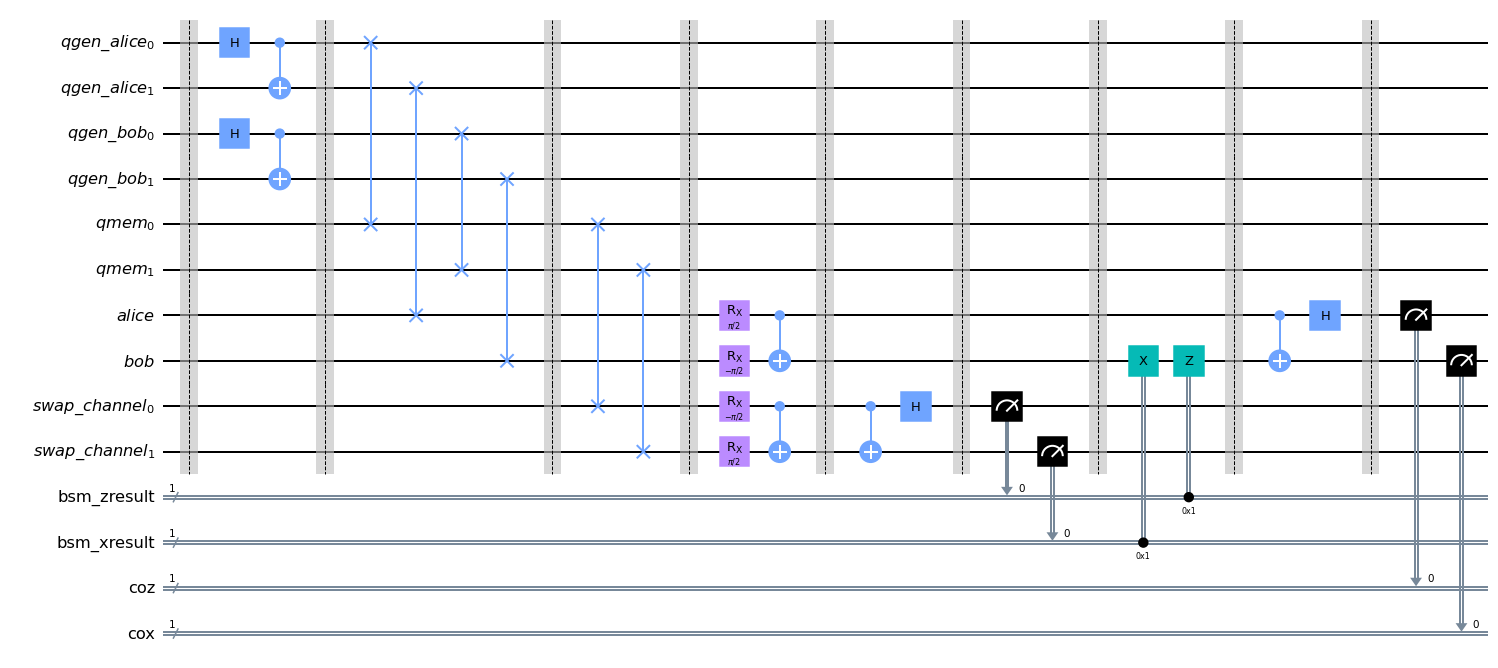

In [134]:
qc.draw("mpl", fold=-1)